In [1]:
#Notebook Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [3]:
houseData=pd.read_csv('/kaggle/input/bostonhoustingmlnd/housing.csv')

## Clean the data

In [4]:
pd.isnull(houseData).any()

RM         False
LSTAT      False
PTRATIO    False
MEDV       False
dtype: bool

## Visualizing Data

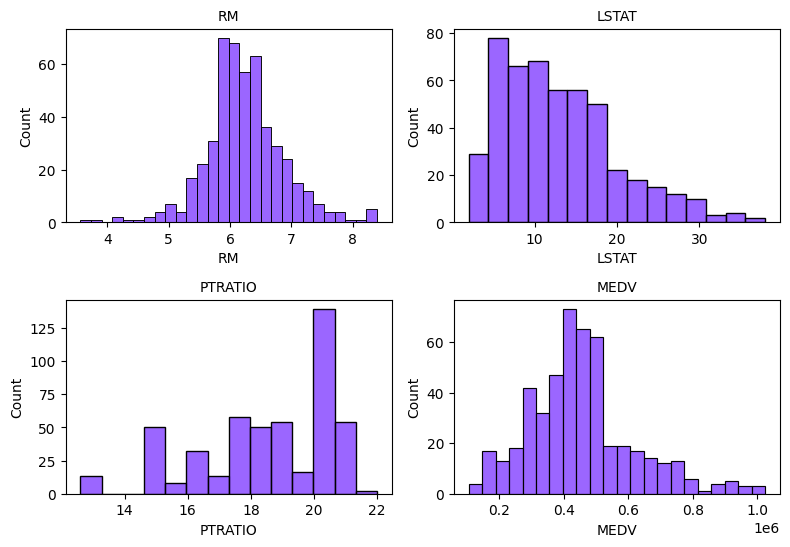

In [14]:
plt.figure(figsize=(8,16))

for i,num in enumerate(houseData.select_dtypes(exclude='O')):
    ax=plt.subplot(6,2,i + 1)
    sns.histplot(x=houseData[num],ec='black',color='#7A33FF')
    plt.title(num, fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
houseData.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


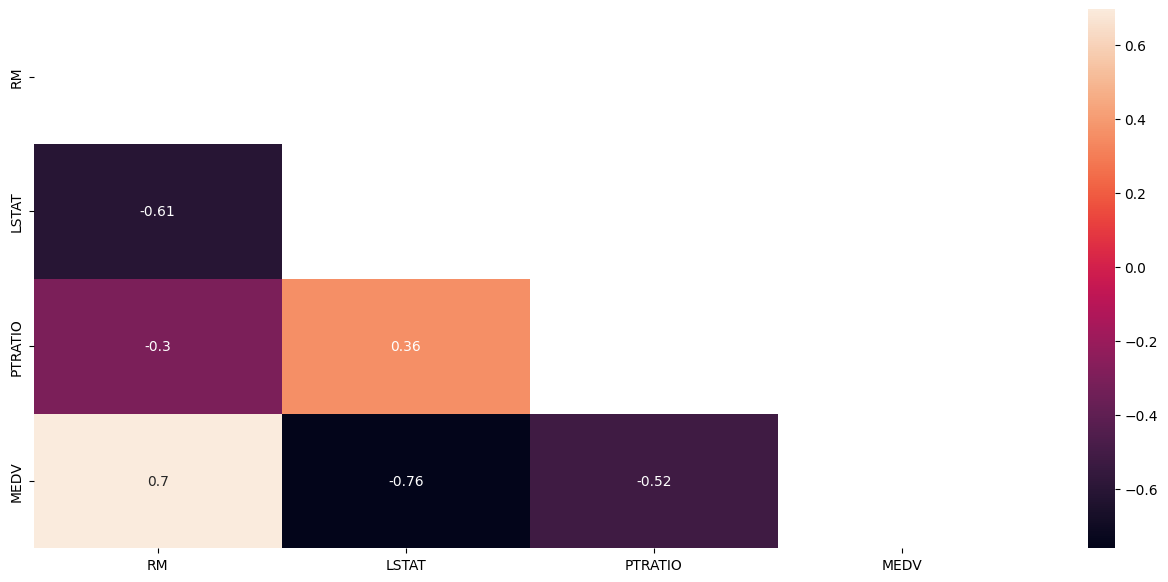

In [9]:
m=np.zeros_like(houseData.corr(numeric_only=True))
tri=np.triu_indices_from(m)
m[tri]=True

plt.figure(figsize=(16,7))
sns.heatmap(houseData.corr(numeric_only=True),mask=m,annot=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

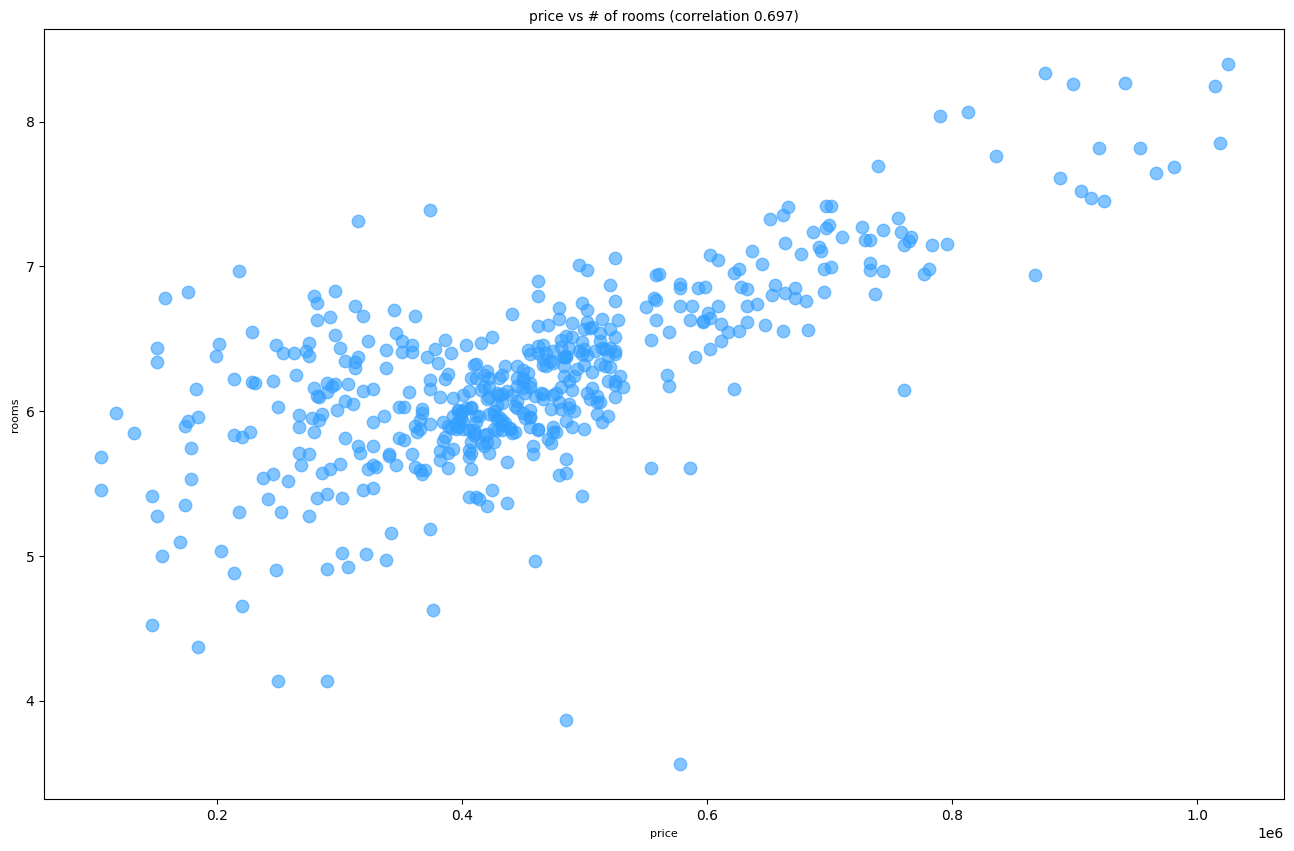

In [13]:
#scatter plot of price vs area
nox=round(houseData['MEDV'].corr(houseData['RM']), 3)
plt.figure(figsize=(16,10))
plt.scatter(x=houseData['MEDV'],y=houseData['RM'], alpha=0.6, s=80, color='#339FFF')
plt.title(f'price vs # of rooms (correlation {nox})', fontsize=10)
plt.xlabel('price',fontsize=8)
plt.ylabel('rooms',fontsize=8)
plt.show

## Regression

In [26]:
value=houseData['MEDV']
attributes=houseData.drop('MEDV',axis=1)

xtrain,xtest,ytrain,ytest=train_test_split(attributes,value,test_size=0.2)

In [27]:
r=LinearRegression()
r.fit(xtrain,ytrain)

print('Training r^2:',r.score(xtrain,ytrain))
print('Test r^2:',r.score(xtest,ytest))

print('I',r.intercept_)
pd.DataFrame(data=r.coef_,index=xtrain.columns,columns=['coef'])

Training r^2: 0.7252384640796694
Test r^2: 0.672884305462554
I 384720.74875755125


,coef
RM,92219.112006
LSTAT,-11092.550242
PTRATIO,-19722.815797


## Transform Data

In [28]:
r.fit(xtrain,ytrain)
s=r.score(xtest,ytest)
s

0.672884305462554

In [29]:
houseData['MEDV'].skew()

0.7750823014749909

In [30]:
ylog=np.log(houseData['MEDV'])
ylog.skew()

-0.5834895036804089

/tmp/ipykernel_48/379022094.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ylog)


<function matplotlib.pyplot.show(close=None, block=None)>

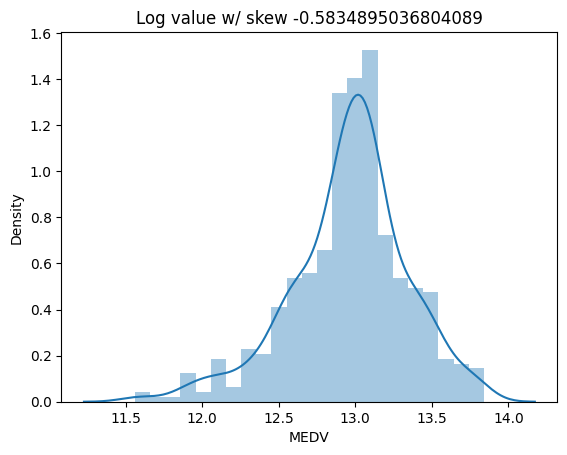

In [31]:
sns.distplot(ylog)
plt.title(f'Log value w/ skew {ylog.skew()}')
plt.show

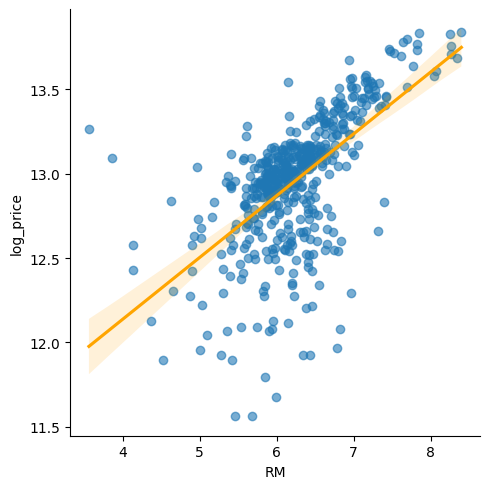

In [32]:
tdata=features
tdata['log_price']=ylog
sns.lmplot(x='RM', y='log_price',data=tdata,scatter_kws={'alpha':0.6}, line_kws={'color':'orange'})
plt.show()

In [35]:
p=np.log(houseData['MEDV']) #use log prices
attributes=houseData.drop('MEDV', axis=1)
xtrain,xtest,ytrain,ytest=train_test_split(attributes,p,test_size=0.2)
r=LinearRegression()
r.fit(xtrain,ytrain)
print('Training r^2:',r.score(xtrain,ytrain))
print('Test r^2:',r.score(xtest,ytest))
print('Intercept',r.intercept_)
pd.DataFrame(data=r.coef_,index=xtrain.columns,columns=['coef'])

Training r^2: 0.6830551721806617
Test r^2: 0.8037862817515313
Intercept 13.533415225753453


,coef
RM,0.092730
LSTAT,-0.032607
PTRATIO,-0.039582


## P-Values

In [39]:
xconst=sm.add_constant(xtrain)
mod=sm.OLS(ytrain,xconst)
res=mod.fit()
pd.DataFrame({'coef':res.params, 'p-value':round(res.pvalues,4)})

,coef,p-value
const,13.533415,0.0
RM,0.092730,0.0
LSTAT,-0.032607,0.0
PTRATIO,-0.039582,0.0


## all attributes pass the p-value test

## multicollinearity

In [38]:
v=[variance_inflation_factor(exog=xconst.values,exog_idx=i) for i in range(xconst.shape[1])]
pd.DataFrame({'coef_name':xconst.columns,'vif':np.around(v,2)})

,coef_name,vif
0,const,293.07
1,RM,1.55
2,LSTAT,1.63
3,PTRATIO,1.18


## Simplification

In [42]:
xconst=sm.add_constant(xtrain)
mod=sm.OLS(ytrain,xconst)
res=mod.fit()
origMod=pd.DataFrame({'coef':res.params,'p-value':round(res.pvalues,4)})
print('bic:',res.bic)
print('r^2:',res.rsquared)

bic: -89.2459322227724
r^2: 0.6830551721806618


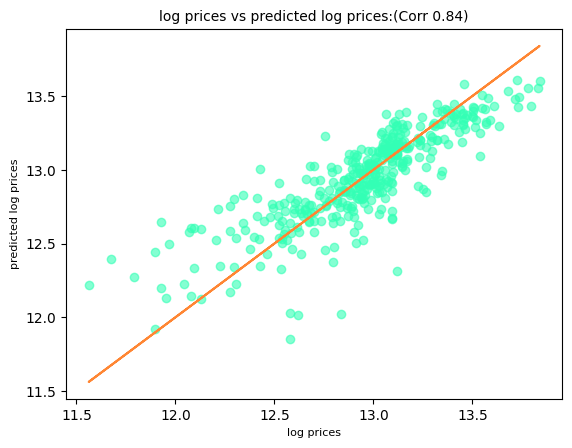

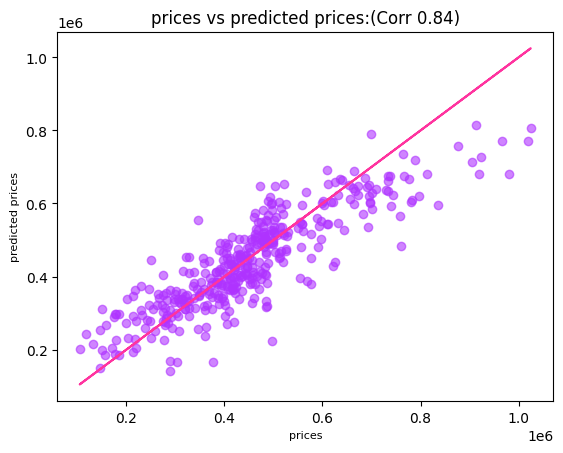

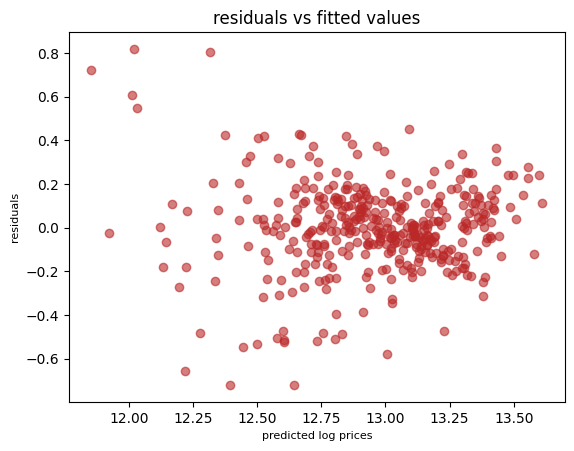

In [49]:
value=np.log(houseData['MEDV'])
attributes=houseData.drop(['MEDV'], axis=1)
xtrain,xtest,ytrain,ytest=train_test_split(attributes,p,test_size=0.2)

xconst=sm.add_constant(xtrain)
mod=sm.OLS(ytrain,xconst)
res=mod.fit()

corr=round(ytrain.corr(res.fittedvalues), 3)
plt.scatter(x=ytrain,y=res.fittedvalues,color='#33FFB5',alpha=0.6)
plt.plot(ytrain,ytrain,color='#FF8633')
plt.xlabel('log prices', fontsize=8)
plt.ylabel('predicted log prices', fontsize=8)
plt.title(f'log prices vs predicted log prices:(Corr {corr})', fontsize=10)
plt.show()

plt.scatter(x=np.e**ytrain,y=np.e**res.fittedvalues,color='#AF33FF', alpha=0.6)
plt.plot(np.e**ytrain,np.e**ytrain,color='#FF339F')

plt.xlabel('prices', fontsize=8)
plt.ylabel('predicted prices', fontsize=8)
plt.title(f'prices vs predicted prices:(Corr {corr})', fontsize=12)

plt.show()

plt.scatter(x=res.fittedvalues,y=res.resid,color='#BB2828', alpha=0.6)
plt.xlabel('predicted log prices', fontsize=8)
plt.ylabel('residuals', fontsize=8)
plt.title('residuals vs fitted values', fontsize=12)

plt.show()


logMSE=round(res.mse_resid,3)
logRSquared=round(res.rsquared,3)

/tmp/ipykernel_48/1426534703.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res.resid,color='#2849BB')


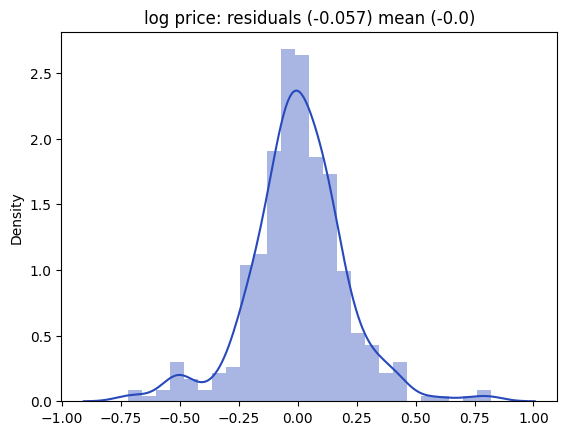

In [51]:
resMean=round(res.resid.mean(),3)
resSkew=round(res.resid.skew(),3)

sns.distplot(res.resid,color='#2849BB')
plt.title(f'log price: residuals ({resSkew}) mean ({resMean})')
plt.show()

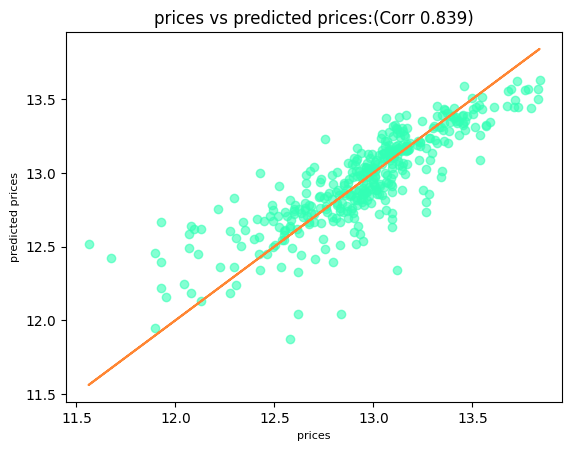

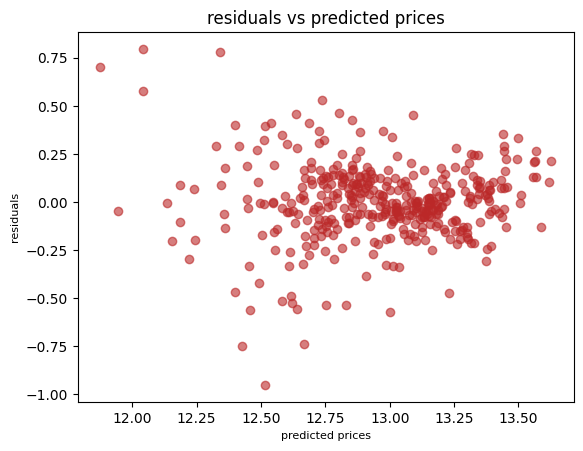

/tmp/ipykernel_48/1906313243.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res.resid,color='#AF33FF')


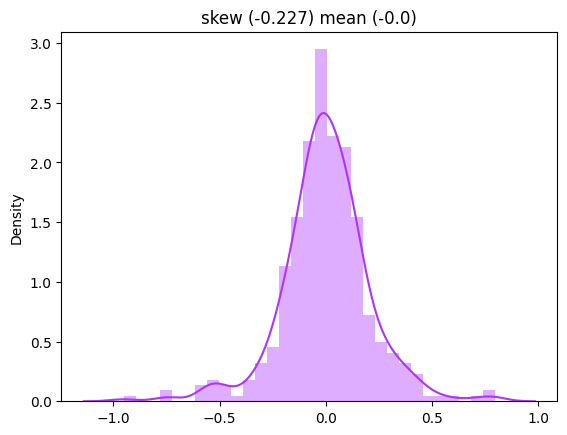

In [55]:
value=houseData['MEDV']
attributes=houseData.drop(['MEDV'],axis=1)
xtrain,xtest,ytrain,ytest=train_test_split(attributes,p,test_size=0.2)

xconst=sm.add_constant(xtrain)
mod=sm.OLS(ytrain,xconst)
res=mod.fit()


corr=round(ytrain.corr(res.fittedvalues),3)
plt.scatter(x=ytrain,y=res.fittedvalues,color='#33FFB5',alpha=0.6)
plt.plot(ytrain,ytrain,color='#FF8633')
plt.xlabel('prices',fontsize=8)
plt.ylabel('predicted prices',fontsize=8)
plt.title(f'prices vs predicted prices:(Corr {corr})',fontsize=12)
plt.show()

plt.scatter(x=res.fittedvalues,y=res.resid,color='#BB2828',alpha=0.6)

plt.xlabel('predicted prices',fontsize=8)
plt.ylabel('residuals',fontsize=8)
plt.title('residuals vs predicted prices',fontsize=12)
plt.show()


resMean=round(res.resid.mean(), 3)
resSkew=round(res.resid.skew(), 3)

sns.distplot(res.resid,color='#AF33FF')
plt.title(f'skew ({resSkew}) mean ({resMean})')
plt.show()

fullMSE=round(res.mse_resid,3)
fullRSquared=round(res.rsquared,3)

In [56]:
pd.DataFrame({'r^2': [logRSquared, fullRSquared],'mse':[logMSE,fullMSE],'rmse':[np.sqrt([logMSE,fullMSE])]},index=['reduced model','full model'])

,r^2,mse,rmse
reduced model,0.706,0.043,"[0.2073644135332772, 0.2073644135332772]"
full model,0.703,0.043,"[0.2073644135332772, 0.2073644135332772]"


In [58]:
print('standard deviation in log values',np.sqrt(logMSE))
print('2 standard deviations in log values',2*np.sqrt(logMSE))

upper=np.log(30)+2*np.sqrt(logMSE)
print('upper bound for a 95% interval',upper)
print('upper bound for values',np.e**upper * 1000)

lower=np.log(30)-2*np.sqrt(logMSE)
print('lower bound for a 95% interval',lower)
print('lower bound for values', np.e**lower * 1000)

standard deviation in log values 0.2073644135332772
2 standard deviations in log values 0.4147288270665544
upper bound for a 95% interval 3.81592620872871
upper bound for values 45418.804200311475
lower bound for a 95% interval 2.986468554595601
lower bound for values 19815.581141914514
